In [32]:
GPU_NUM = 0
GPU_NUM = str(GPU_NUM)
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_NUM

import gc
import h5py
import glob
import natsort
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from IPython.display import clear_output
warnings.filterwarnings("ignore")
# plt.style.use('seaborn-v0_8-white')

from scipy.signal import hilbert
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
GPU = torch.device('cuda')
CPU = torch.device('cpu')
print(torch.cuda.is_available(), ': ', torch.cuda.get_device_name(0))

True :  NVIDIA GeForce RTX 3080


In [58]:
def resample_col(x, W_p):
    B, C, D, W = x.shape
    x = x.permute(0, 2, 1, 3).reshape(B * D, C, W)  # (B*D, C, W)
    x = F.interpolate(x, size=W_p, mode='linear', align_corners=False)
    x = x.reshape(B, D, C, W_p).permute(0, 2, 1, 3)  # (B, C, D, W_p)
    return x    

In [34]:
class DAS():
    def __init__(self, H_p=374, W_p=128, N=128, H_m=0.038, W_m=0.038, 
                 sos=1540, freq=7.6e6, sampling=4.1118):
        self.H_p = H_p
        self.W_p = W_p
        self.N = N
        self.H_m = H_m
        self.W_m = W_m
        self.sos = sos
        self.freq = freq
        self.sampling = sampling

        # scale factors
        self.p2m_H = H_m / H_p
        self.p2m_W = W_m / W_p
        self.m2l = freq / sos
        self.l2s = sampling

        x = torch.arange(H_p).view(-1, 1, 1) * self.p2m_H     # (H_p, 1, 1)
        y = torch.arange(W_p).view(1, -1, 1) * self.p2m_W     # (1, W_p, 1)
        n = torch.arange(N).view(1, 1, -1) * self.p2m_W       # (1, 1, N)

        M1 = x * (self.m2l * self.l2s)                        # (H_p, 1, 1)
        M2 = torch.sqrt((y - n) ** 2 + x ** 2) * (self.m2l * self.l2s)  # (H_p, W_p, N)
        M = M1 + M2                                           # (H_p, W_p, N)

        self.M1 = torch.round(M1).long()
        self.M2 = torch.round(M2).long()
        self.M  = torch.round(M).long()
        print(f'{"Indexing Matrix":<30}: {self.M.shape}')

        self.idx_n = torch.arange(N).long()
        self.idx_y = torch.arange(W_p).long()
        self.idx_x = torch.arange(H_p).long()

        # Resampler
        if W_p!=128:
            self.resampler = resample_col
            self.W_p = W_p
        else:
            self.resampler = None

        # Dynamic Aperture
        list_sigma = torch.linspace(0.01, 1, H_p) ** 0.3
        list_sigma = list_sigma * 5 + 1
        list_s = [-s for s in range(0, N)]
        x = torch.stack([torch.linspace(s, s + N - 1, N) for s in list_s])
        self.mask_DA = torch.stack([torch.exp(-0.5 * (x / sigma) ** 2) for sigma in list_sigma]).unsqueeze(0).unsqueeze(0)  # (1, 1, H_p, N, N)

    def das(self, RF, Ne=None, Nf=None, ensemble=True, PA=False, DA=True):
        if not isinstance(RF, torch.Tensor):
            RF = torch.tensor(RF, dtype=torch.float32)
        elif RF.dtype != torch.float32:
            RF = RF.to(torch.float32)

        if self.resampler:
            print(f'{"Resampling RF Column":<30}: {RF.shape[-1]} -> {self.W_p}')
            RF = self.resampler(RF, self.W_p)

        print(f'{"RF(Raw)":<30}: {RF.shape}')
        if Ne is not None:
            RF = RF[Ne, :, :, :]
        if Nf is not None:
            RF = RF[:, Nf, :, :]
        print(f'{"RF(Target)":<30}: {RF.shape}')
        
        # Index clamping
        M_idx = self.M2 if PA else self.M
        M_idx = M_idx.clamp(0, RF.shape[-2] - 1)

        RF_res = RF[:, :, M_idx, self.idx_n]
        print(f'{"Extracted":<30}: {RF_res.shape}')

        if DA:
            RF_res = RF_res * self.mask_DA.to(RF_res.device)
            print(f'{"Dynamic Aperture Mask":<30}: {self.mask_DA.shape}')

        RF_res = RF_res.sum(dim=-1).float()
        print(f'{"RF_res":<30}: {RF_res.shape}')

        if ensemble:
            RF_res = RF_res.mean(dim=0)
            print(f'{"RF_res(AGG)":<30}: {RF_res.shape}')

        print('--' * 30)
        return RF_res


In [35]:
class HP():
    def __init__(self):
        self.H = 256
        self.W = 256
        self.N = 256
        
        self.depth = 0.038
        self.width = 0.038
        self.p2m_H = (self.depth/self.H)
        self.p2m_W = (self.width/self.W)
        self.m2l = (7.6e+6/1540)
        self.l2s = 4.1118

hp = HP()
hp.__dict__

{'H': 256,
 'W': 256,
 'N': 256,
 'depth': 0.038,
 'width': 0.038,
 'p2m_H': 0.0001484375,
 'p2m_W': 0.0001484375,
 'm2l': 4935.064935064935,
 'l2s': 4.1118}

In [36]:
RF_data = torch.from_numpy(scipy.io.loadmat('../data/data_sample.mat')['RF_data']).to(torch.float32)
RF_data = RF_data[:, :5, :, :]
print('RF_data: ', RF_data.shape)

RF_data:  torch.Size([1, 5, 2176, 128])


In [37]:
das = DAS(H_p=hp.H, W_p=hp.W, N=hp.N)
res = das.das(RF_data)

Indexing Matrix               : torch.Size([256, 256, 256])
Resampling RF Column          : 128 -> 256
RF(Raw)                       : torch.Size([1, 5, 2176, 256])
RF(Target)                    : torch.Size([1, 5, 2176, 256])
Extracted                     : torch.Size([1, 5, 256, 256, 256])
Dynamic Aperture Mask         : torch.Size([1, 1, 256, 256, 256])
RF_res                        : torch.Size([1, 5, 256, 256])
RF_res(AGG)                   : torch.Size([5, 256, 256])
------------------------------------------------------------


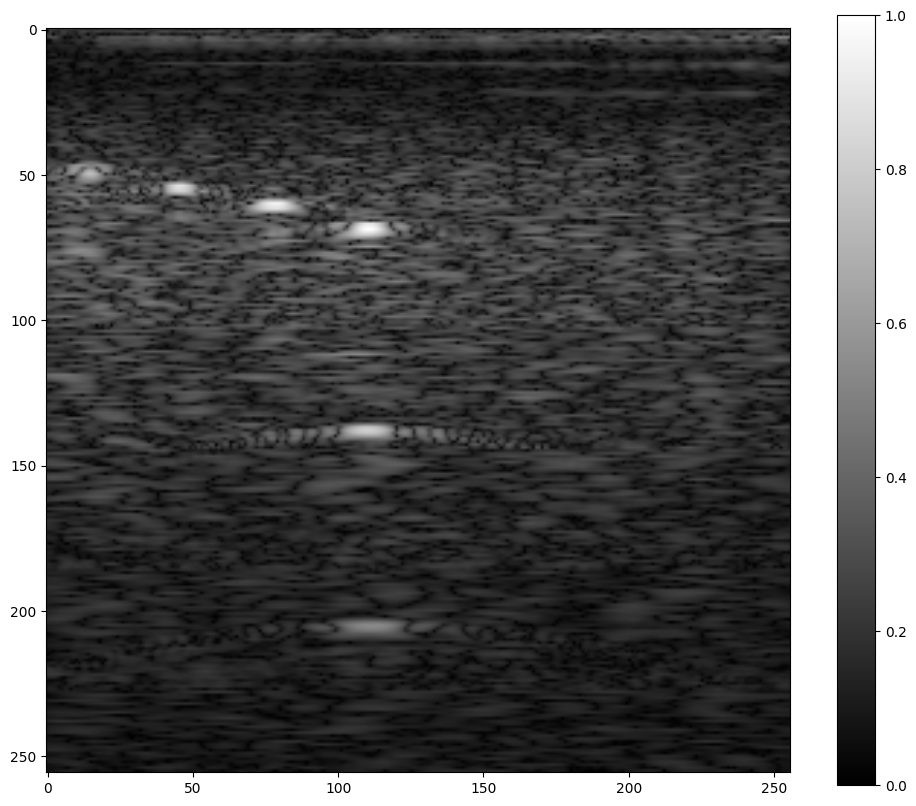

In [71]:
img = res[0]
img = np.abs(img)
img = 20*np.log10(img+1e-3)
img = (img-img.min())/(img.max()-img.min())
img = img**4.5
plt.figure(figsize=(12, 10))
plt.imshow(img, 'gray', interpolation='bilinear')
plt.colorbar(); plt.show()